# Gunpla Pricing Project

Gunpla model kits have a large range of prices, from those that cost only a few dollars and to some that cost just shy of $1000. Not only do their MRSP price vary, but their second hand market varies even moreso. These model kits are produced in a limited quantity in Japan with no set schedule. For some model kits, the time between reprints could be a few months or a few years. This limited quantity causes prices to surge during long times between reprints. However, once a reprint is announced, pricing typically returns back to MSRP. 

The intent behind this project is to analyze the current pricing of gunpla model kits in relation to their size, starting price, and time since their release date or their last reprint. 

In [135]:
#importing libraries that will be used 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
from datetime import datetime

### Testing BeautifulSoup

The first step in this project will be testing out the BeautifulSoup library to scrape data from websites on gunpla names and pricing. There are hundreds of gunpla model kits in existence, but there already exists a rudimentary website, gunpladb.com, that stores data hundreds of gunpla model kits, making it a great source to pull data from. 

In [6]:
from bs4 import BeautifulSoup
import requests

URL_test1 = 'https://www.gunpladb.com/entry/1219'
page = requests.get(URL_test1).text
soup = BeautifulSoup(page, 'lxml')

match = soup.find('div', class_='col-lg-7 col-md-7 col-sm-10 col-xs-10 col-xs-offset-1 col-sm-offset-1 col-md-offset-0 col-lg-offset-0')
print(match)

#after viewing the page elements, this class was determined to contain the required information I was looking to process: 
#Grade, Scale, Release Date, and Price at Release

<div class="col-lg-7 col-md-7 col-sm-10 col-xs-10 col-xs-offset-1 col-sm-offset-1 col-md-offset-0 col-lg-offset-0" style="border: 1px solid gray; padding: 25px; font-size: 18px;">
<strong>Grade: </strong>Master Grade<br/>
<strong>Scale: </strong>1/100<br/>
<strong>Universe: </strong>Universal Century<br/>
<strong>Jancode: </strong>4902425579191<br/>
<strong>Origin: </strong>Mobile Suit Gundam 0083: Stardust Memory<br/>
<strong>Release Date: </strong>08/01/1997<br/>
<strong>Price at Release: </strong>¥2700<br/>
<br/>
<br/>
<div class="text-center"><a href="https://www.amazon.com/Bandai-Hobby-GUNDAM-Master-Action/dp/B00030EV6G%3FSubscriptionId%3DAKIAJDVKP7OKAUNBDTMA%26tag%3Dgunpladb-20%26linkCode%3Dxm2%26camp%3D2025%26creative%3D165953%26creativeASIN%3DB00030EV6G"><button class="btn btn-danger btn-lg" type="button">Find on Amazon</button></a></div>
<div class="row"> </div>
<!--<div class="row">

                      <a href="/entry/"><button type="button" class="btn btn-default pull-lef

In [3]:
title = soup.title.text
main_title = title.split('|')

metrics = list(match.stripped_strings)

print(main_title)
print(metrics)

#testing methods on getting the main characteristics
#each metric does not have a unique class so instead, it has to be indexed from the list

['MG RX-78 GP01 GUNDAM GP01 ZEPHYRANTHES ', ' MG ガンダムRX-78GP01 ', ' Gunpla DB']
['Grade:', 'Master Grade', 'Scale:', '1/100', 'Universe:', 'Universal Century', 'Jancode:', '4902425579191', 'Origin:', 'Mobile Suit Gundam 0083: Stardust Memory', 'Release Date:', '08/01/1997', 'Price at Release:', '¥2700', 'Find on Amazon']


In [4]:
len(metrics)

15

In [5]:
for i in range(len(metrics)):
    print(metrics[i])

Grade:
Master Grade
Scale:
1/100
Universe:
Universal Century
Jancode:
4902425579191
Origin:
Mobile Suit Gundam 0083: Stardust Memory
Release Date:
08/01/1997
Price at Release:
¥2700
Find on Amazon


In [6]:
keymetrics = ['N/A'] * 7
counter = 0
for i in range(len(metrics)):
    if metrics[i] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:'] and \
    metrics[i+1] not in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:']:
        keymetrics[counter] = metrics[i+1]
        counter += 1
    elif metrics[i] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:'] and \
    metrics[i+1] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:']:
        counter += 1
        
keymetrics    

#after some testing, some pages contained blanks in their metrics which screwed up the counts in the for loop
#this for loop was made in response so that it correctly accounts for blanks in the list

['Master Grade',
 '1/100',
 'Universal Century',
 '4902425579191',
 'Mobile Suit Gundam 0083: Stardust Memory',
 '08/01/1997',
 '¥2700']

In [34]:
URL_test2 = 'https://www.gunpladb.com/entry/1238'
page = requests.get(URL_test2).text
soup = BeautifulSoup(page, 'lxml')
match = soup.p.text
match

#this website stores gunpla entries in a numerical format. However, there are certain pages that do not have any data
#numbers 1237 and 1239 are valid gunpla entries so there is no identifiable last valid entry I can stop at
#This string below will be used later as reference to skip this page

"We're sorry, but something went wrong and the page cannot be displayed."

In [47]:
URL_test3 = 'https://www.gunpladb.com/entry/1400'
page = requests.get(URL_test3).text
soup = BeautifulSoup(page, 'lxml')
match = soup.body.center.text
match

#since there are no identifiable last entry, I chose a number that was total amount of gunplas they supposedly had and added 200
#this would help ensure that nearly all entries are added 
#This string below will be used later as reference to skip this page

'\n\n            This Gunpla does not exist or is not approved by administration yet. Please try searching again.\n\n        \n\n\n\nGunpla101 \n\n  | About | Feedback\n\n  | Stats\n\n\n'

In [54]:
exist_error = match
exist_error

'\n\n            This Gunpla does not exist or is not approved by administration yet. Please try searching again.\n\n        \n\n\n\nGunpla101 \n\n  | About | Feedback\n\n  | Stats\n\n\n'

### Setting up the dataframe

After the above testing on how to properly scrape the data from the website and accounting for any errors, we are now ready to create the dataframe. This will take pages 0 to 1400 and add the metrics below to the dataframe

In [89]:
columns = ['Name', 'Grade', 'Scale', 'Universe', 'JAPCODE', 'Series', 'Release_date', 'Cost(yen)']
df = pd.DataFrame(columns = columns)
df

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen)


In [90]:
counter = 0
for page_number in range(0,1400):
    
    URL = 'https://www.gunpladb.com/entry/' + str(page_number)
    page = requests.get(URL).text
    soup = BeautifulSoup(page, 'lxml')
    
    ##Check for Page error or does not exist
    
    if (soup.p.text != "We're sorry, but something went wrong and the page cannot be displayed.") and (soup.body.center.text != exist_error):
        counter += 1
        title = soup.title.text
        main_title = title.split('|')
        
        match = soup.find('div', class_='col-lg-7 col-md-7 col-sm-10 col-xs-10 col-xs-offset-1 col-sm-offset-1 col-md-offset-0 col-lg-offset-0')
        metrics = list(match.stripped_strings)
        
        keymetrics = ['N/A'] * 7
        offset = 0
        for i in range(len(metrics)):
            if metrics[i] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:'] and \
            metrics[i+1] not in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:']:
                keymetrics[offset] = metrics[i+1]
                offset += 1
            elif metrics[i] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:'] and \
            metrics[i+1] in ['Grade:', 'Scale:', 'Universe:', 'Jancode:', 'Origin:', 'Release Date:', 'Price at Release:']:
                offset += 1

        parameters = pd.DataFrame(data = {columns[0]:[main_title[0]], columns[1]:[keymetrics[0]], columns[2]:[keymetrics[1]], 
                                  columns[3]:[keymetrics[2]], columns[4]:[keymetrics[3]], columns[5]:[keymetrics[4]], 
                                  columns[6]:[keymetrics[5]], columns[7]:[keymetrics[6]]})
        df = df.append(parameters, ignore_index = True)
        
        if counter % 50 == 0:
            print('Added', counter, 'entries.')
            
print('Added a total of', counter, 'entries.')
df.head()            

Added 50 entries.
Added 100 entries.
Added 150 entries.
Added 200 entries.
Added 250 entries.
Added 300 entries.
Added 350 entries.
Added 400 entries.
Added 450 entries.
Added 500 entries.
Added 550 entries.
Added 600 entries.
Added 650 entries.
Added 700 entries.
Added 750 entries.
Added 800 entries.
Added 850 entries.
Added 900 entries.
Added 950 entries.
Added 1000 entries.
Added 1050 entries.
Added 1100 entries.
Added 1150 entries.
Added 1200 entries.
Added a total of 1209 entries.


,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen)
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320
1,BB214 Kihei Densetsu Knight Wing Gundam Zero,Super Deformed,No Scale,Universal Century,4543112003676,SD Gundam Eiyusen,01/2001,¥500
2,SD MA-08 Byg-Zam,Super Deformed,No Scale,Universal Century,4543112003683,Mobile Suit Gundam,01/2001,¥432
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240
4,HGUC MSM-07S Char's Z'Gok,High Grade,1/144,Universal Century,4543112005687,Mobile Suit Gundam,02/2001,¥756


In [91]:
df.to_csv('gunpla_db.csv', index = False)
#saving the data 

In [7]:
gunplas = pd.read_csv('gunpla_db.csv')
gunplas.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen)
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320
1,BB214 Kihei Densetsu Knight Wing Gundam Zero,Super Deformed,No Scale,Universal Century,4543112003676,SD Gundam Eiyusen,01/2001,¥500
2,SD MA-08 Byg-Zam,Super Deformed,No Scale,Universal Century,4543112003683,Mobile Suit Gundam,01/2001,¥432
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240
4,HGUC MSM-07S Char's Z'Gok,High Grade,1/144,Universal Century,4543112005687,Mobile Suit Gundam,02/2001,¥756


### Reprint Information

Now we are going to add the reprint date information to the dataframe we just created. The main source for the reprint calendar is from Bandai's website, however it is all in Japanese. Fortunately, reddit user cslevens posts a translated list of gunpla reprints and their respective dates. Unfortunately, his naming conventions do not 100% match the naming convention in the dataframe and his dates vary in format and are just typed out in a reddit post. 

We use get_close_matches() from difflib to match names as close as possible. For the dates, this was a more difficult approach where each post was added manually to an excel file. He only had 2 years worth of data, which would later be expounded upon after reviewing the final results, but there are no consistent records for these reprint schedules so this is the best we can work with. 

In [8]:
from difflib import get_close_matches

def get_closest_match(name):
    matches = get_close_matches(name, gunplas['Name'], n = 1, cutoff = 0.7)
    if len(matches) > 0:
        return matches[0]
    else:
        return None 

In [9]:
reprints = pd.read_excel('CLEANEDDATES.xlsx')
reprints['ClosestMatch'] = reprints['NAME_1'].apply(get_closest_match)
reprints

,NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch
0,HG Gundam Exia,2022-03-14,High Grade,1/144,MG Gundam Exia
1,HG Union Flag,2022-03-14,High Grade,1/144,None
2,HG Gundam Dynames,2022-03-28,High Grade,1/144,None
3,HG Gundam Kyrios,2022-03-24,High Grade,1/144,None
4,HG Gundam Virtue,2022-03-28,High Grade,1/144,HGAW Gundam Airmaster
...,...,...,...,...,...
1322,SD Xiahou Dun Tallgeese III,2021-03-18,Super Deformed,No Scale,None
1323,SD Sangoku Haro (Dragon Tattoo),2021-03-18,Super Deformed,No Scale,None
1324,SD Xiahou Yuan Tallgeese,2021-03-25,Super Deformed,No Scale,None
1325,SD Sun Ce Gundam Astray (Blue Frame),2021-03-25,Super Deformed,No Scale,Gundam Astray Blue Frame


In [10]:
reprints_clean = reprints[reprints.ClosestMatch.notnull()]
reprints_clean

,NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch
0,HG Gundam Exia,2022-03-14,High Grade,1/144,MG Gundam Exia
4,HG Gundam Virtue,2022-03-28,High Grade,1/144,HGAW Gundam Airmaster
5,HG Reborns Gundam,2022-03-24,High Grade,1/144,HG Raider Gundam
6,HG Double O Gundam (Seven Sword/G),2022-03-28,High Grade,1/144,SD 00 Gundam Seven Sword/G
9,HGBF Wing Gundam Zero Honoo,2022-03-14,High Grade,1/144,HGAC Wing Gundam Zero
...,...,...,...,...,...
1315,RG Gundam Banshee Norn,2021-03-25,Real Grade,1/144,SD Unicorn Gundam 02 Banshee Norn
1316,RG Nu Gundam,2021-03-22,Real Grade,1/144,SD Nu Gundam
1319,SD Sun Quan Gundam Astray (Red Frame),2021-03-18,Super Deformed,No Scale,SD Gundam Astray Red Frame
1325,SD Sun Ce Gundam Astray (Blue Frame),2021-03-25,Super Deformed,No Scale,Gundam Astray Blue Frame


In [11]:
gunplasdate = gunplas.merge(reprints_clean, how = 'left', left_on = 'Name', right_on = 'ClosestMatch')
gunplasdate

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer
1,BB214 Kihei Densetsu Knight Wing Gundam Zero,Super Deformed,No Scale,Universal Century,4543112003676,SD Gundam Eiyusen,01/2001,¥500,NaN,NaT,NaN,NaN,NaN
2,SD MA-08 Byg-Zam,Super Deformed,No Scale,Universal Century,4543112003683,Mobile Suit Gundam,01/2001,¥432,NaN,NaT,NaN,NaN,NaN
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom
4,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-08-30,Master Grade,1/100,MG MS-07B-3 Gouf Custom
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Kihei Densetsu Musha Gundam,Super Deformed,No Scale,SD Gundam,4902425782102,SD Gundam Eiyusen,11/1/2000,¥432,NaN,NaT,NaN,NaN,NaN
1727,Maganac (SD),Super Deformed,No Scale,After Colony,4902425782119,New Mobile Report Gundam Wing,12/1/2000,¥432,NaN,NaT,NaN,NaN,NaN
1728,MG RX-93 Nu Gundam,Master Grade,1/144,Universal Century,4902425782126,Mobile Suit Gundam: Char's Counterattack,12/1/2000,¥5400,NaN,NaT,NaN,NaN,NaN
1729,HGUC RX-78 GP01Fb Gundam GP01 Full Vernian,High Grade,1/144,Universal Century,4902425782133,Mobile Suit Gundam 0083: Stardust Memory,12/1/2000,¥1620,NaN,NaT,NaN,NaN,NaN


In [12]:
gunplasdate = gunplasdate.drop_duplicates(subset = ['JAPCODE'])
gunplasdate

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer
1,BB214 Kihei Densetsu Knight Wing Gundam Zero,Super Deformed,No Scale,Universal Century,4543112003676,SD Gundam Eiyusen,01/2001,¥500,NaN,NaT,NaN,NaN,NaN
2,SD MA-08 Byg-Zam,Super Deformed,No Scale,Universal Century,4543112003683,Mobile Suit Gundam,01/2001,¥432,NaN,NaT,NaN,NaN,NaN
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom
6,HGUC MSM-07S Char's Z'Gok,High Grade,1/144,Universal Century,4543112005687,Mobile Suit Gundam,02/2001,¥756,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Kihei Densetsu Musha Gundam,Super Deformed,No Scale,SD Gundam,4902425782102,SD Gundam Eiyusen,11/1/2000,¥432,NaN,NaT,NaN,NaN,NaN
1727,Maganac (SD),Super Deformed,No Scale,After Colony,4902425782119,New Mobile Report Gundam Wing,12/1/2000,¥432,NaN,NaT,NaN,NaN,NaN
1728,MG RX-93 Nu Gundam,Master Grade,1/144,Universal Century,4902425782126,Mobile Suit Gundam: Char's Counterattack,12/1/2000,¥5400,NaN,NaT,NaN,NaN,NaN
1729,HGUC RX-78 GP01Fb Gundam GP01 Full Vernian,High Grade,1/144,Universal Century,4902425782133,Mobile Suit Gundam 0083: Stardust Memory,12/1/2000,¥1620,NaN,NaT,NaN,NaN,NaN


### Cleaning up some data

Now that all the reprints have been added there are some entries that do not quite match. Gundam names are the same even with multiple scales so there are cases when get_closest_match have the wrong scale matched to it as seen below. To correct that, all the unmatching entries are taken out. 

The dates were all cleaned up to be in a uniform format as well so that it can be properly compared. Another column was then added that used the release date if there is no reprint date associated. 

In addition, another column was added for the USD cost. This process was not as simple as converting Yen to USD. Importing costs from Japan needs to be taken into account along with inflation in pricing since some of the oldest models original release dates are in the 90s. There is no single website that has all the current pricing in USD so an average between a few websites were taken in addition to a random assortment of models were chosen. This resulted in a constant that the Yen value can be multiplied by to get a good ballpark of the current USD price. 

In [13]:
print(gunplasdate['Grade'] == gunplasdate['Grade_1'])

0        True
1       False
2       False
3        True
6       False
        ...  
1726    False
1727    False
1728    False
1729    False
1730    False
Length: 1209, dtype: bool


In [14]:
gunpla_db = pd.concat([gunplasdate.query('Grade == Grade_1'), gunplasdate[gunplasdate['Grade_1'].isna()]])
gunpla_db.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,¥7560,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,¥432,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,¥1080,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam


In [15]:
gunpla_db['Release_date_clean'] = pd.to_datetime(gunpla_db['Release_date']).dt.strftime('%Y-%m-%d')
gunpla_db.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,¥7560,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,¥432,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,¥1080,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01


In [16]:
gunpla_db['DATE_1'].fillna(gunpla_db['Release_date_clean'], inplace = True)
gunpla_db

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,¥4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,¥3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,¥7560,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,¥432,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,¥1080,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Kihei Densetsu Musha Gundam,Super Deformed,No Scale,SD Gundam,4902425782102,SD Gundam Eiyusen,11/1/2000,¥432,NaN,2000-11-01,NaN,NaN,NaN,2000-11-01
1727,Maganac (SD),Super Deformed,No Scale,After Colony,4902425782119,New Mobile Report Gundam Wing,12/1/2000,¥432,NaN,2000-12-01,NaN,NaN,NaN,2000-12-01
1728,MG RX-93 Nu Gundam,Master Grade,1/144,Universal Century,4902425782126,Mobile Suit Gundam: Char's Counterattack,12/1/2000,¥5400,NaN,2000-12-01,NaN,NaN,NaN,2000-12-01
1729,HGUC RX-78 GP01Fb Gundam GP01 Full Vernian,High Grade,1/144,Universal Century,4902425782133,Mobile Suit Gundam 0083: Stardust Memory,12/1/2000,¥1620,NaN,2000-12-01,NaN,NaN,NaN,2000-12-01


In [17]:
gunpla_db['Cost(yen)'] = gunpla_db['Cost(yen)'].replace({'\¥' : ''}, regex = True)
gunpla_db.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,4320,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,3240,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,7560,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,432,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,1080,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01


In [18]:
gunpla_db['Cost(yen)'] = gunpla_db['Cost(yen)'].astype(float)
gunpla_db.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,4320.0,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,3240.0,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,7560.0,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,432.0,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,1080.0,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01


In [19]:
gunpla_db['Cost_USD'] = (gunpla_db['Cost(yen)']/134.45)*1.7
gunpla_db.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean,Cost_USD
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,4320.0,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01,54.622536
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,3240.0,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01,40.966902
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,7560.0,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01,95.589438
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,432.0,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01,5.462254
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,1080.0,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01,13.655634


In [175]:
gunpla_db1 = gunpla_db
gunpla_db1.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean,Cost_USD,Current_Price,days_since_print,price_delta
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,4320.0,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01,54.622536,90.0,146.0,35.377464
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,3240.0,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01,40.966902,79.99,487.0,39.023098
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,7560.0,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01,95.589438,195.98,247.0,100.390562
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,432.0,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01,5.462254,21.24,487.0,15.777746
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,1080.0,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01,13.655634,52.19,86.0,38.534366


### Second hand pricing

Using above web-scraping methods, we now apply that method for getting second hand pricing. Ebay is a popular website to buy these model kits second hand and we will be using it to add a current price column to our dataframe. After appending the current ebay price to the dataframe, we can use this to calculate the percent change in the price of the model kit. Percent change would be a better tracker than overall price change as it takes into account the large discrepancies in pricing. Since not all gunpla kits might be found on ebay, we will be taking out any rows that do not find a price. 

In [251]:
counter = 0
current_price = []
for name, grade in zip(gunpla_db['Name'], gunpla_db['Grade']):
   
    print(f'Looking up {name} price. ')
    searchterm = name.replace(' ','+') + grade.replace(' ','+') + '+bandai+' 
    ebay_url = f'https://www.ebay.com/sch/i.html?_from=R40&_nkw={searchterm}&_sacat=0&LH_TitleDesc=0&rt=nc'
    page = requests.get(ebay_url).text
    soup = BeautifulSoup(page, 'lxml')
    check = soup.find('h3', class_ = 'srp-save-null-search__heading')
    fewer_results = soup.find_all('span', class_ = 'BOLD')
    if check is None:
        info = soup.find_all('span', class_ = "s-item__price")
        price = info[1].text
        price = price.replace('$', '').replace(',', '')
        try:
            price = float(price)
        except ValueError:
            print(f'Could not find a price for {name}.')
            current_price.append('NaN')
            continue
        else:
            current_price.append(price)
            print(f'Completed adding {name} at a price of {price}.') 
            counter += 1
    elif len(fewer_results) > 2 and fewer_results[2].text == 'Results matching fewer words':
        info = soup.find_all('span', class_ = "s-item__price")
        price = info[1].text
        price = price.replace('$', '').replace(',', '')
        try:
            price = float(price)
        except ValueError:
            print(f'Could not find a price for {name}.')
            current_price.append('NaN')
            continue
        else:
            current_price.append(price)
            print(f'Completed adding {name} at a price of {price}.') 
            counter += 1
    else:
        print(f'Could not find a price for {name}.')
        current_price.append('NaN')

print(f'Found {counter} prices.')

Looking up MG MS-18E Kampfer  price. 
Completed adding MG MS-18E Kampfer  at a price of 90.0.
Looking up MG MS-07B-3 Gouf Custom  price. 
Completed adding MG MS-07B-3 Gouf Custom  at a price of 79.99.
Looking up MG ZGMF-X20A Strike Freedom Gundam Full Burst Mode  price. 
Completed adding MG ZGMF-X20A Strike Freedom Gundam Full Burst Mode  at a price of 195.98.
Looking up SD Master Gundam  price. 
Completed adding SD Master Gundam  at a price of 25.0.
Looking up HGUC RX-78-2 Gundam  price. 
Completed adding HGUC RX-78-2 Gundam  at a price of 52.19.
Looking up SD MS06-F Zaku II  price. 
Completed adding SD MS06-F Zaku II  at a price of 91.57.
Looking up MG RGM-79(G) GM Ground Type  price. 
Completed adding MG RGM-79(G) GM Ground Type  at a price of 74.99.
Looking up HGUC RMS-141 Xekueins  price. 
Completed adding HGUC RMS-141 Xekueins  at a price of 85.0.
Looking up HGUC MS-14Fs Gelgoog Marine Cima Custom   price. 
Completed adding HGUC MS-14Fs Gelgoog Marine Cima Custom   at a price of 

Completed adding HGUC Full Armor 7th Gundam   at a price of 38.3.
Looking up MG Gundam Exia Ignition Mode  price. 
Completed adding MG Gundam Exia Ignition Mode  at a price of 70.0.
Looking up SD RX-78-2 Gundam (Animation Color)   price. 
Could not find a price for SD RX-78-2 Gundam (Animation Color)  .
Looking up MG RX-75 Guntank   price. 
Completed adding MG RX-75 Guntank   at a price of 120.99.
Looking up SD Oda Nobunaga Gundam   price. 
Completed adding SD Oda Nobunaga Gundam   at a price of 14.99.
Looking up HGUC NZ-666 Kshatriya   price. 
Completed adding HGUC NZ-666 Kshatriya   at a price of 99.99.
Looking up MG Gundam Astray Blue Frame Second Revise   price. 
Completed adding MG Gundam Astray Blue Frame Second Revise   at a price of 58.99.
Looking up HGUC RX-0 Unicorn Gundam Destroy Mode   price. 
Completed adding HGUC RX-0 Unicorn Gundam Destroy Mode   at a price of 38.9.
Looking up HGUC RX-0 Unicorn Gundam Unicorn Mode   price. 
Completed adding HGUC RX-0 Unicorn Gundam Unico

Completed adding HG R17 Perfect Strike Gundam   at a price of 34.85.
Looking up HGUC MS-06R-1A Shin Matsunaga's Customize Zaku II   price. 
Completed adding HGUC MS-06R-1A Shin Matsunaga's Customize Zaku II   at a price of 27.83.
Looking up SD Sazabi   price. 
Completed adding SD Sazabi   at a price of 33.0.
Looking up HG Gundam Astray Blue Frame Second L   price. 
Completed adding HG Gundam Astray Blue Frame Second L   at a price of 21.99.
Looking up HGUC PMX-000 Messala   price. 
Completed adding HGUC PMX-000 Messala   at a price of 90.0.
Looking up HGUC Base Jabber Type 89   price. 
Completed adding HGUC Base Jabber Type 89   at a price of 16.12.
Looking up MG Wing Gundam Proto Zero EW   price. 
Completed adding MG Wing Gundam Proto Zero EW   at a price of 85.0.
Looking up MG RX-78-2 Gundam Ver.3.0   price. 
Completed adding MG RX-78-2 Gundam Ver.3.0   at a price of 105.0.
Looking up HGUC AGX-04 Gerbera Tetra   price. 
Completed adding HGUC AGX-04 Gerbera Tetra   at a price of 37.11

Completed adding SD Qubeley Triple Collection  at a price of 56.66.
Looking up MG FA-010A Fazz   price. 
Completed adding MG FA-010A Fazz   at a price of 4.88.
Looking up Gundam Blue Destiny (SD)   price. 
Completed adding Gundam Blue Destiny (SD)   at a price of 6.16.
Looking up Hyaku Shiki & Mega Bazooka Launcher (SD)   price. 
Completed adding Hyaku Shiki & Mega Bazooka Launcher (SD)   at a price of 39.6.
Looking up Yoroimaru  price. 
Completed adding Yoroimaru  at a price of 39.99.
Looking up MG MSZ-006A1 Zeta Plus Test Color Type  price. 
Completed adding MG MSZ-006A1 Zeta Plus Test Color Type  at a price of 66.83.
Looking up MG GF13-017NJ II God Gundam   price. 
Completed adding MG GF13-017NJ II God Gundam   at a price of 38.34.
Looking up AMA-X2 Neue-Ziel (SD)   price. 
Completed adding AMA-X2 Neue-Ziel (SD)   at a price of 68.12.
Looking up RX-77-2 Gun Cannon (SD)   price. 
Completed adding RX-77-2 Gun Cannon (SD)   at a price of 24.39.
Looking up Buoh Gundam  price. 
Completed

Completed adding 1/100 Launcher Strike Gundam   at a price of 429.0.
Looking up Mobile BuCUE   price. 
Completed adding Mobile BuCUE   at a price of 24.69.
Looking up Quick Model Buster Gundam  price. 
Completed adding Quick Model Buster Gundam  at a price of 38.68.
Looking up EX Gundam SEED Mecha Set 1   price. 
Completed adding EX Gundam SEED Mecha Set 1   at a price of 49.51.
Looking up Freedom Gundam   price. 
Completed adding Freedom Gundam   at a price of 37.95.
Looking up HG ZGMF-1017 Mobile Ginn  price. 
Completed adding HG ZGMF-1017 Mobile Ginn  at a price of 39.99.
Looking up HG GAT-X207 Blitz Gundam  price. 
Completed adding HG GAT-X207 Blitz Gundam  at a price of 55.19.
Looking up 1/100 Buster Gundam  price. 
Completed adding 1/100 Buster Gundam  at a price of 260.0.
Looking up 1/60 Gundam Striker Weapon System  price. 
Completed adding 1/60 Gundam Striker Weapon System  at a price of 255.02.
Looking up MG GF13-017NJ II Hyper Mode God Gundam  price. 
Completed adding MG GF1

Completed adding EX FFMH-Y-101 Eternal   at a price of 99.99.
Looking up Yonen Gunshi Raigan  price. 
Completed adding Yonen Gunshi Raigan  at a price of 5.99.
Looking up HGUC Gundam Mk-II + Flying Armor   price. 
Completed adding HGUC Gundam Mk-II + Flying Armor   at a price of 62.18.
Looking up MG RX-78-2 Gundam (One Year War 0079 Ver.)   price. 
Could not find a price for MG RX-78-2 Gundam (One Year War 0079 Ver.)  .
Looking up Gounetsu Karakuri-shi ZZ  price. 
Completed adding Gounetsu Karakuri-shi ZZ  at a price of 5.99.
Looking up MG RB-79K Ball The 08MS Ver.   price. 
Completed adding MG RB-79K Ball The 08MS Ver.   at a price of 6.59.
Looking up PG Sky Grasper + Aile Striker   price. 
Completed adding PG Sky Grasper + Aile Striker   at a price of 422.76.
Looking up Onmitsu Ninja Noomaru  price. 
Completed adding Onmitsu Ninja Noomaru  at a price of 5.99.
Looking up HGUC RX-121-1 Hazel-Custom   price. 
Completed adding HGUC RX-121-1 Hazel-Custom   at a price of 52.19.
Looking up 

Completed adding HGUC RX-79BD-3 Blue Destiny Unit 3   at a price of 64.82.
Looking up HGUC MSN-03 Jagd Doga Gunneys Guss Use   price. 
Completed adding HGUC MSN-03 Jagd Doga Gunneys Guss Use   at a price of 53.71.
Looking up HGUC MSN-03 Jagd Doga Quess Ea Use   price. 
Completed adding HGUC MSN-03 Jagd Doga Quess Ea Use   at a price of 50.28.
Looking up MG ZGMF-X42S Destiny Gundam  price. 
Completed adding MG ZGMF-X42S Destiny Gundam  at a price of 100.0.
Looking up MG ZGMF-X42S Destiny Gundam Extreme Blast Mode  price. 
Completed adding MG ZGMF-X42S Destiny Gundam Extreme Blast Mode  at a price of 100.0.
Looking up SD Sousou Gundam   price. 
Completed adding SD Sousou Gundam   at a price of 25.0.
Looking up Speed Grade Collection Wing Gundam  price. 
Completed adding Speed Grade Collection Wing Gundam  at a price of 50.69.
Looking up MG MS-14A Gelgoog Ver.2.0   price. 
Completed adding MG MS-14A Gelgoog Ver.2.0   at a price of 119.99.
Looking up U.C. HARD GRAPH Principality of Zeon Cy

Completed adding SD Koumei Re-GZ Shuyu Hyaku Shiki Red Cliff Special Set   at a price of 92.77.
Looking up SD Gigataifu Shibai Sazabi   price. 
Completed adding SD Gigataifu Shibai Sazabi   at a price of 36.21.
Looking up HGUC Strum Dias   price. 
Completed adding HGUC Strum Dias   at a price of 58.22.
Looking up MG MS-07B Gouf Ver.2.0   price. 
Completed adding MG MS-07B Gouf Ver.2.0   at a price of 74.95.
Looking up SD Joko Serpent   price. 
Completed adding SD Joko Serpent   at a price of 14.99.
Looking up SD Sonshoko Gerbera   price. 
Completed adding SD Sonshoko Gerbera   at a price of 14.99.
Looking up MG G Armor Real Type Color   price. 
Completed adding MG G Armor Real Type Color   at a price of 290.0.
Looking up MG MS-06J Zaku II Ver.2.0 White Ogre   price. 
Completed adding MG MS-06J Zaku II Ver.2.0 White Ogre   at a price of 69.99.
Looking up HGUC Ewac-Zack   price. 
Completed adding HGUC Ewac-Zack   at a price of 69.99.
Looking up SD Sohi Gundam   price. 
Completed adding S

Completed adding MG MS-07B-3 Gouf Custom   at a price of 79.99.
Looking up MG GF13-017NJ II God Gundam  price. 
Completed adding MG GF13-017NJ II God Gundam  at a price of 38.34.
Looking up MG GAT-X105 Aile Strike Gundam Ver.RM  price. 
Completed adding MG GAT-X105 Aile Strike Gundam Ver.RM  at a price of 112.98.
Looking up MG YMS-15 Gyan  price. 
Completed adding MG YMS-15 Gyan  at a price of 67.95.
Looking up MG RX-93-2 Hi-v Gundam  price. 
Completed adding MG RX-93-2 Hi-v Gundam  at a price of 17.99.
Looking up MG RX - 75 Guntank   price. 
Completed adding MG RX - 75 Guntank   at a price of 120.99.
Looking up MG MS-09 Dom  price. 
Completed adding MG MS-09 Dom  at a price of 109.99.
Looking up MG RX-78-2 Gundam Ver. O.Y.W 0079 Animation Color  price. 
Completed adding MG RX-78-2 Gundam Ver. O.Y.W 0079 Animation Color  at a price of 99.0.
Looking up MG GAT-X105E Strike Noir Gundam  price. 
Completed adding MG GAT-X105E Strike Noir Gundam  at a price of 21.81.
Looking up MG Gundam Ast

Could not find a price for Suisei Gundam -Kirahagane Gokusai- (SD)  .
Looking up Guren Gundam -Kirahagane Gokusai- (SD)   price. 
Could not find a price for Guren Gundam -Kirahagane Gokusai- (SD)  .
Looking up Kaiser Gundam -Kirahagane Gokusai- (SD)   price. 
Could not find a price for Kaiser Gundam -Kirahagane Gokusai- (SD)  .
Looking up Tensei Daishogun -Kirahagane Gokusai- (SD)   price. 
Could not find a price for Tensei Daishogun -Kirahagane Gokusai- (SD)  .
Looking up SD Shin Sangokuden Trinity Set (RyuteiKen Awakening Ver.)   price. 
Could not find a price for SD Shin Sangokuden Trinity Set (RyuteiKen Awakening Ver.)  .
Looking up SD Shin Kakuka Virsago   price. 
Completed adding SD Shin Kakuka Virsago   at a price of 39.79.
Looking up SD Shin Ryomo Dijeh, Kannei Kampfer, Assault Navy Set   price. 
Completed adding SD Shin Ryomo Dijeh, Kannei Kampfer, Assault Navy Set   at a price of 78.25.
Looking up Gouenbui Daishogun -Kirahagane Gokusai- (SD)   price. 
Could not find a price f

Could not find a price for SD Gundam AGE-3 (Normal, Fortress ,Orbital)  .
Looking up HGUC ReZEL Type-C (Defenser b Unit/General Revil)   price. 
Could not find a price for HGUC ReZEL Type-C (Defenser b Unit/General Revil)  .
Looking up HGUC Base Jabber (Unicorn Ver.)   price. 
Completed adding HGUC Base Jabber (Unicorn Ver.)   at a price of 73.81.
Looking up RG ZGMF-X09A Justice Gundam   price. 
Completed adding RG ZGMF-X09A Justice Gundam   at a price of 70.0.
Looking up HGUC MS-06R-1A Black Tri-Stars Zaku II   price. 
Completed adding HGUC MS-06R-1A Black Tri-Stars Zaku II   at a price of 69.99.
Looking up MG GAT-X103 Buster Gundam   price. 
Completed adding MG GAT-X103 Buster Gundam   at a price of 84.0.
Looking up RG 1/144 Rx-78-2 Gundam Ver GFT  price. 
Completed adding RG 1/144 Rx-78-2 Gundam Ver GFT  at a price of 70.16.
Looking up SD Legend BB Commando Gundam   price. 
Completed adding SD Legend BB Commando Gundam   at a price of 27.95.
Looking up MG GAT-X303 Aegis Gundam   pri

Completed adding PG RX-0 [N] Unicorn Gundam 02 Banshee Norn   at a price of 419.29.
Looking up MG Gundam Amazing Red Warrior   price. 
Completed adding MG Gundam Amazing Red Warrior   at a price of 107.88.
Looking up Gundam MK-II (A.E.U.G.) (HGUC) Revive  price. 
Could not find a price for Gundam MK-II (A.E.U.G.) (HGUC) Revive .
Looking up Gundam MK-II (Titans) (HGUC)   price. 
Completed adding Gundam MK-II (Titans) (HGUC)   at a price of 48.53.
Looking up RG XXXG-01W Wing Gundam EW   price. 
Completed adding RG XXXG-01W Wing Gundam EW   at a price of 58.73.
Looking up RG GNT-0000 00 QAN[T]   price. 
Completed adding RG GNT-0000 00 QAN[T]   at a price of 43.99.
Looking up SD Legend BB Knight Superior Dragon   price. 
Completed adding SD Legend BB Knight Superior Dragon   at a price of 43.75.
Looking up HGUC Full Armor Unicorn Gundam (Destroy Mode/Red Color Ver.)   price. 
Could not find a price for HGUC Full Armor Unicorn Gundam (Destroy Mode/Red Color Ver.)  .
Looking up Jagd Doga (SD

Completed adding Burn Knight F91 (SD)   at a price of 29.95.
Looking up SD Fourth Gundam Dai Shogun  price. 
Completed adding SD Fourth Gundam Dai Shogun  at a price of 14.99.
Looking up King Gundam II (SD)   price. 
Completed adding King Gundam II (SD)   at a price of 14.99.
Looking up Gundam F90 P, V (SD)   price. 
Completed adding Gundam F90 P, V (SD)   at a price of 50.0.
Looking up SD Hakuryuu Gundam  price. 
Completed adding SD Hakuryuu Gundam  at a price of 6.99.
Looking up SD Seiryuu Gundam  price. 
Completed adding SD Seiryuu Gundam  at a price of 25.0.
Looking up SD Sekiryuu Gundam  price. 
Completed adding SD Sekiryuu Gundam  at a price of 25.0.
Looking up SD Sennari Dai Shogun  price. 
Completed adding SD Sennari Dai Shogun  at a price of 147.26.
Looking up Musha F91  price. 
Completed adding Musha F91  at a price of 253.0.
Looking up Musha Heavy Gundam  price. 
Completed adding Musha Heavy Gundam  at a price of 14.99.
Looking up Musha Full Armor Gundam  price. 
Completed a

Completed adding OZ-13MSX2 Mercurius   at a price of 90.0.
Looking up SD Master Dai Shougun  price. 
Completed adding SD Master Dai Shougun  at a price of 5.99.
Looking up XXXG-01S Shenlong Gundam  price. 
Completed adding XXXG-01S Shenlong Gundam  at a price of 82.5.
Looking up SD Blade Gundam  price. 
Completed adding SD Blade Gundam  at a price of 25.0.
Looking up 1/60 Wing Gundam 0  price. 
Completed adding 1/60 Wing Gundam 0  at a price of 269.0.
Looking up HG 1/100 XXXG-00W0 Wing Gundam Zero  price. 
Completed adding HG 1/100 XXXG-00W0 Wing Gundam Zero  at a price of 19.95.
Looking up OZ-13MS Gundam Epyon   price. 
Completed adding OZ-13MS Gundam Epyon   at a price of 34.79.
Looking up MG MS-06S Char's Zaku II  price. 
Completed adding MG MS-06S Char's Zaku II  at a price of 88.02.
Looking up XXXG-00W0 Wing Gundam Zero  price. 
Completed adding XXXG-00W0 Wing Gundam Zero  at a price of 19.95.
Looking up MG MS-06F/J Zaku II  price. 
Completed adding MG MS-06F/J Zaku II  at a price

Completed adding MSN-04 Sazabi (SD)   at a price of 211.7.
Looking up MSN-03 Jagd-Doga (SD)   price. 
Completed adding MSN-03 Jagd-Doga (SD)   at a price of 99.56.
Looking up RGZ-91B Re-Gz Custom (SD)   price. 
Completed adding RGZ-91B Re-Gz Custom (SD)   at a price of 149.99.
Looking up Geara Doga Custom (SD)   price. 
Completed adding Geara Doga Custom (SD)   at a price of 49.99.
Looking up FA-178 Full Armor Gundam Mk-II (SD)   price. 
Completed adding FA-178 Full Armor Gundam Mk-II (SD)   at a price of 39.99.
Looking up Zaku III Custom (SD)   price. 
Completed adding Zaku III Custom (SD)   at a price of 49.99.
Looking up MS-14B J-Ridden's Gelgoog (SD)   price. 
Completed adding MS-14B J-Ridden's Gelgoog (SD)   at a price of 34.99.
Looking up Zeong (Last Ver.) (SD)   price. 
Could not find a price for Zeong (Last Ver.) (SD)  .
Looking up NRX-055-1 Gates Bound Doc (SD)   price. 
Completed adding NRX-055-1 Gates Bound Doc (SD)   at a price of 89.99.
Looking up MSZ-010 ZZ-Gundam FXA-08R

Could not find a price for XXXG-01H Gundam Heavy Arms (With Figure) .
Looking up XXXG-01SR Gundam Sandrock (With Figure)  price. 
Could not find a price for XXXG-01SR Gundam Sandrock (With Figure) .
Looking up OZ-13MS Gundam Epyon (With Figure)  price. 
Could not find a price for OZ-13MS Gundam Epyon (With Figure) .
Looking up Vayeate  price. 
Completed adding Vayeate  at a price of 91.99.
Looking up Mercurius  price. 
Completed adding Mercurius  at a price of 91.99.
Looking up HGUC RX-78 GP01 Gundam GP01 ZEPHYRANTHES  price. 
Completed adding HGUC RX-78 GP01 Gundam GP01 ZEPHYRANTHES  at a price of 26.99.
Looking up HGUC AMX-011 Zaku III  price. 
Completed adding HGUC AMX-011 Zaku III  at a price of 84.0.
Looking up MG FA-010S Full Armor ZZ Gundam  price. 
Completed adding MG FA-010S Full Armor ZZ Gundam  at a price of 135.87.
Looking up New Gundam (HWS Ver.) (SD)   price. 
Could not find a price for New Gundam (HWS Ver.) (SD)  .
Looking up Tallgeese (SD)   price. 
Completed adding Tal

In [259]:
gunpla_db1['Current_Price'] = current_price
gunpla_db1.head()

,Name,Grade,Scale,Universe,JAPCODE,Series,Release_date,Cost(yen),NAME_1,DATE_1,Grade_1,Scale_1,ClosestMatch,Release_date_clean,Cost_USD,Current_Price,days_since_print,price_delta
0,MG MS-18E Kampfer,Master Grade,1/100,Universal Century,4543112003669,Mobile Suit Gundam 0080: War in the Pocket,01/2001,4320.0,MG Kampfer,2022-01-27,Master Grade,1/100,MG MS-18E Kampfer,2001-01-01,54.622536,90.0,146.0,35.377464
3,MG MS-07B-3 Gouf Custom,Master Grade,1/100,Universal Century,4543112005670,Mobile Suit Gundam: The 08th MS Team,02/2001,3240.0,MG Gouf Custom,2021-02-20,Master Grade,1/100,MG MS-07B-3 Gouf Custom,2001-02-01,40.966902,79.99,487.0,39.023098
10,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,Master Grade,1/100,Cosmic Era,4543112007414,Mobile Suit Gundam SEED,12/1/2006,7560.0,MG Strike Freedom Gundam Full Burst Mode,2021-10-18,Master Grade,1/100,MG ZGMF-X20A Strike Freedom Gundam Full Burst ...,2006-12-01,95.589438,195.98,247.0,100.390562
11,SD Master Gundam,Super Deformed,No Scale,Future Century,4543112008862,Mobile Fighter G Gundam,3/1/2001,432.0,SD Dian Wei Master Gundam,2021-02-20,Super Deformed,No Scale,SD Master Gundam,2001-03-01,5.462254,25.0,487.0,15.777746
22,HGUC RX-78-2 Gundam,High Grade,1/144,Universal Century,4543112024077,Mobile Suit Gundam,05/01/2001,1080.0,HGUC RX-78-2 Gundam,2022-03-28,High Grade,1/144,HGUC RX-78-2 Gundam,2001-05-01,13.655634,52.19,86.0,38.534366


In [253]:
date_format = '%Y-%m-%d'
days_past = []
today = datetime.strptime('2022-06-22', date_format)
for release_date, reprint_date in zip(gunpla_db1['Release_date_clean'], gunpla_db1['DATE_1']):
    if reprint_date == 'NaN':
        delta = today - release_date
    else: 
        delta = today - reprint_date
    
    days_past.append(delta.days)

In [254]:
gunpla_db1['days_since_print'] = days_past

In [264]:
gunpla_db2 = gunpla_db1.loc[(gunpla_db1['Cost_USD'] != 0.0)]
gunpla_db2 = gunpla_db2.loc[(gunpla_db1['Current_Price'] != 'NaN')]
gunpla_db2 = gunpla_db2.astype({'Current_Price' : 'float'})

In [265]:
gunpla_db2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053 entries, 0 to 1730
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                1053 non-null   object        
 1   Grade               1053 non-null   object        
 2   Scale               1053 non-null   object        
 3   Universe            977 non-null    object        
 4   JAPCODE             1053 non-null   int64         
 5   Series              1053 non-null   object        
 6   Release_date        1053 non-null   object        
 7   Cost(yen)           1053 non-null   float64       
 8   NAME_1              198 non-null    object        
 9   DATE_1              1053 non-null   datetime64[ns]
 10  Grade_1             198 non-null    object        
 11  Scale_1             198 non-null    object        
 12  ClosestMatch        198 non-null    object        
 13  Release_date_clean  1053 non-null   object      

In [267]:
gunpla_db3 = gunpla_db2[['Grade', 'Cost_USD', 'Current_Price', 'days_since_print']].copy()
gunpla_db3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053 entries, 0 to 1730
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Grade             1053 non-null   object 
 1   Cost_USD          1053 non-null   float64
 2   Current_Price     1053 non-null   float64
 3   days_since_print  1053 non-null   float64
dtypes: float64(3), object(1)
memory usage: 41.1+ KB


In [277]:
percent_change = []
for past, present in zip(gunpla_db3['Cost_USD'], gunpla_db3['Current_Price']):
    if present < past:
        percent = 0
    else:
        delta = present - past
        percent = (delta/past)
    
    percent_change.append(percent)

In [279]:
gunpla_db3['Percent_Change'] = percent_change
gunpla_db3 = gunpla_db3.loc[(gunpla_db3['Percent_Change'] != 0)]
gunpla_db3

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change
0,Master Grade,54.622536,90.00,146.0,0.647672
3,Master Grade,40.966902,79.99,487.0,0.952552
10,Master Grade,95.589438,195.98,247.0,1.050227
11,Super Deformed,5.462254,25.00,487.0,3.576865
22,High Grade,13.655634,52.19,86.0,2.821866
...,...,...,...,...,...
1716,Super Deformed,5.462254,18.55,7903.0,2.396034
1726,Super Deformed,5.462254,28.63,7903.0,4.241426
1727,Super Deformed,5.462254,6.99,7873.0,0.279692
1728,Master Grade,68.278170,109.99,7873.0,0.610910


In [280]:
gunpla_db3['Grade'].unique()

array(['Master Grade', 'Super Deformed', 'High Grade', 'Perfect Grade',
       'Real Grade', 'No Grade', 'EX Model', 'U.C. Hard Graph',
       'Speed Grade', 'HCM', 'Mega Size'], dtype=object)

### Selecting which kits to use

In the values below, we can see there are many different types of scale grades that we have in the dataframe. However, there are some scales that are not very common and are mainly limited release items that are not often reprinted if at all. Scales starting from UC Hard Graph and below are typically not grouped together with the other model kits and will be removed from the dataframe. 

Once that is done, we will create dummy variables of the different scale grades of model kits. 

In [281]:
gunpla_db3['Grade'].value_counts()

Super Deformed     409
High Grade         223
Master Grade       183
No Grade            80
Real Grade          18
Perfect Grade       17
U.C. Hard Graph      6
Mega Size            4
EX Model             3
Speed Grade          2
HCM                  2
Name: Grade, dtype: int64

In [282]:
gunpla_db4 = gunpla_db3.loc[gunpla_db3['Grade'].isin(['Super Deformed', 'High Grade', 'Master Grade', 'No Grade', 'Perfect Grade', 'Real Grade'])]
gunpla_db4

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change
0,Master Grade,54.622536,90.00,146.0,0.647672
3,Master Grade,40.966902,79.99,487.0,0.952552
10,Master Grade,95.589438,195.98,247.0,1.050227
11,Super Deformed,5.462254,25.00,487.0,3.576865
22,High Grade,13.655634,52.19,86.0,2.821866
...,...,...,...,...,...
1716,Super Deformed,5.462254,18.55,7903.0,2.396034
1726,Super Deformed,5.462254,28.63,7903.0,4.241426
1727,Super Deformed,5.462254,6.99,7873.0,0.279692
1728,Master Grade,68.278170,109.99,7873.0,0.610910


In [283]:
dummies = pd.get_dummies(gunpla_db4.Grade)
dummies

,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
0,0,1,0,0,0,0
3,0,1,0,0,0,0
10,0,1,0,0,0,0
11,0,0,0,0,0,1
22,1,0,0,0,0,0
...,...,...,...,...,...,...
1716,0,0,0,0,0,1
1726,0,0,0,0,0,1
1727,0,0,0,0,0,1
1728,0,1,0,0,0,0


In [284]:
gunpla_db5 = pd.concat([gunpla_db4, dummies], axis  = 1)
gunpla_db5

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
0,Master Grade,54.622536,90.00,146.0,0.647672,0,1,0,0,0,0
3,Master Grade,40.966902,79.99,487.0,0.952552,0,1,0,0,0,0
10,Master Grade,95.589438,195.98,247.0,1.050227,0,1,0,0,0,0
11,Super Deformed,5.462254,25.00,487.0,3.576865,0,0,0,0,0,1
22,High Grade,13.655634,52.19,86.0,2.821866,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1716,Super Deformed,5.462254,18.55,7903.0,2.396034,0,0,0,0,0,1
1726,Super Deformed,5.462254,28.63,7903.0,4.241426,0,0,0,0,0,1
1727,Super Deformed,5.462254,6.99,7873.0,0.279692,0,0,0,0,0,1
1728,Master Grade,68.278170,109.99,7873.0,0.610910,0,1,0,0,0,0


In [331]:
gunpla_dbHG = gunpla_db5.loc[(gunpla_db5['High Grade'] == 1)]
gunpla_dbMG = gunpla_db5.loc[(gunpla_db5['Master Grade'] == 1)]
gunpla_dbNG = gunpla_db5.loc[(gunpla_db5['No Grade'] == 1)]
gunpla_dbPG = gunpla_db5.loc[(gunpla_db5['Perfect Grade'] == 1)]
gunpla_dbRG = gunpla_db5.loc[(gunpla_db5['Real Grade'] == 1)]
gunpla_dbSD = gunpla_db5.loc[(gunpla_db5['Super Deformed'] == 1)]

In [288]:
gunpla_dbHG

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
22,High Grade,13.655634,52.19,86.0,2.821866,1,0,0,0,0,0
42,High Grade,21.849015,85.00,107.0,2.890336,1,0,0,0,0,0
57,High Grade,20.483451,56.54,100.0,1.760277,1,0,0,0,0,0
61,High Grade,21.849015,70.00,107.0,2.203806,1,0,0,0,0,0
73,High Grade,13.655634,29.95,121.0,1.193234,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1674,High Grade,13.655634,34.99,8026.0,1.562312,1,0,0,0,0,0
1695,High Grade,16.386761,26.99,7995.0,0.647061,1,0,0,0,0,0
1696,High Grade,20.483451,84.00,7964.0,3.100871,1,0,0,0,0,0
1704,High Grade,16.386761,87.12,7964.0,4.316487,1,0,0,0,0,0


## Plotting the data

Using matplotlib, we will now plot the data to see if there are any easily discernible patterns and outliers. This will be done for each scale grade and then outliers removed. 

### High Grade

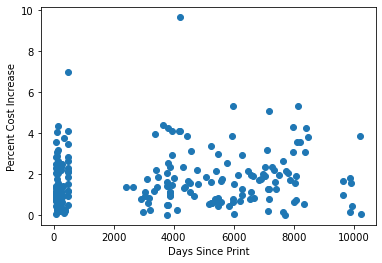

In [298]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbHG['days_since_print'], gunpla_dbHG['Percent_Change'])

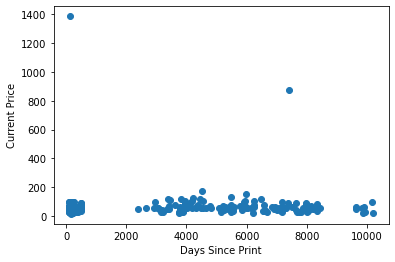

In [300]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbHG['days_since_print'], gunpla_dbHG['Current_Price'])

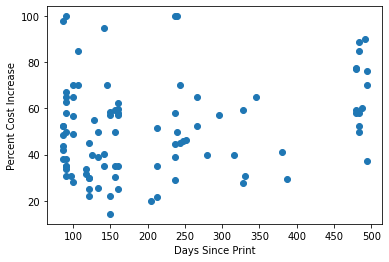

In [306]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
x = gunpla_dbHG.loc[(gunpla_dbHG['Current_Price'] < 300) & (gunpla_dbHG['days_since_print'] < 1000), 'days_since_print']
y = gunpla_dbHG.loc[(gunpla_dbHG['Current_Price'] < 300) & (gunpla_dbHG['days_since_print'] < 1000), 'Current_Price']
plt.scatter(x, y)

In [317]:
df = gunpla_dbHG.loc[gunpla_dbHG['Current_Price'] > 300]
df

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
1203,High Grade,341.390852,1386.99,107.0,3.062763,1,0,0,0,0,0
65,High Grade,382.357754,875.98,7418.0,1.290996,1,0,0,0,0,0


In [318]:
dfHG = gunpla_dbHG.loc[gunpla_dbHG['Current_Price'] < 300]

### Master Grade

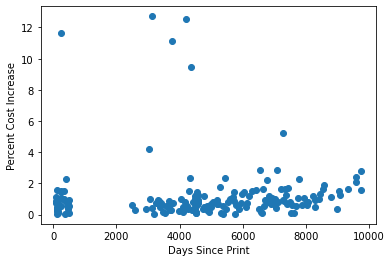

In [307]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbMG['days_since_print'], gunpla_dbMG['Percent_Change'])

In [320]:
dfMG = gunpla_dbMG.loc[gunpla_dbMG['Percent_Change'] < 3]
dfMG.head()

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
0,Master Grade,54.622536,90.00,146.0,0.647672,0,1,0,0,0,0
3,Master Grade,40.966902,79.99,487.0,0.952552,0,1,0,0,0,0
10,Master Grade,95.589438,195.98,247.0,1.050227,0,1,0,0,0,0
34,Master Grade,40.966902,74.99,480.0,0.830502,0,1,0,0,0,0
117,Master Grade,43.698029,85.14,135.0,0.948372,0,1,0,0,0,0


### Perfect Grade

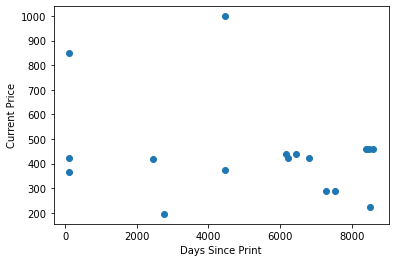

In [321]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbPG['days_since_print'], gunpla_dbPG['Current_Price'])

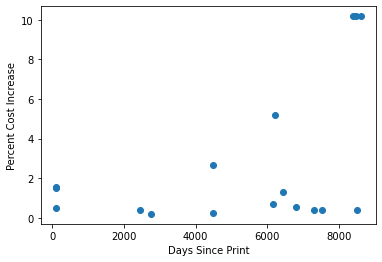

In [322]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbPG['days_since_print'], gunpla_dbPG['Percent_Change'])

In [323]:
dfPG = gunpla_dbPG.loc[gunpla_dbPG['Current_Price'] < 500]
dfPG.head()

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
537,Perfect Grade,245.801413,365.00,107.0,0.484939,0,0,0,1,0,0
1555,Perfect Grade,163.867609,420.70,107.0,1.567316,0,0,0,1,0,0
52,Perfect Grade,204.834511,289.00,7538.0,0.410895,0,0,0,1,0,0
85,Perfect Grade,204.834511,288.99,7296.0,0.410846,0,0,0,1,0,0
127,Perfect Grade,273.112681,420.70,6808.0,0.540390,0,0,0,1,0,0


### Real Grade

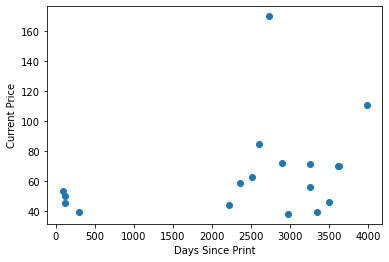

In [324]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbRG['days_since_print'], gunpla_dbRG['Current_Price'])

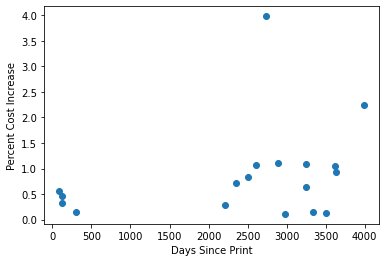

In [326]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbRG['days_since_print'], gunpla_dbRG['Percent_Change'])

In [334]:
dfRG = gunpla_dbRG.loc[gunpla_dbRG['Current_Price'] < 100]
dfRG.head()

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
825,Real Grade,34.139085,44.95,125.0,0.316673,0,0,0,0,1,0
873,Real Grade,34.139085,49.99,125.0,0.464304,0,0,0,0,1,0
1003,Real Grade,34.139085,52.93,90.0,0.550422,0,0,0,0,1,0
1010,Real Grade,34.139085,39.31,296.0,0.151466,0,0,0,0,1,0
1018,Real Grade,34.139085,70.00,3616.0,1.050436,0,0,0,0,1,0


### Super Deformed

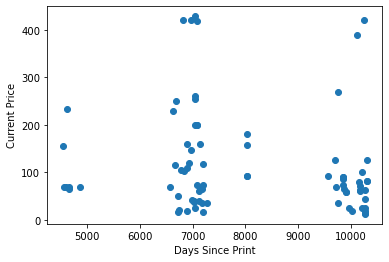

In [329]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbNG['days_since_print'], gunpla_dbNG['Current_Price'])

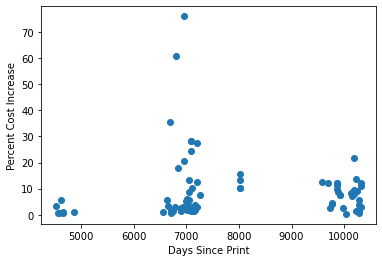

In [328]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbNG['days_since_print'], gunpla_dbNG['Percent_Change'])

In [333]:
dfSD = gunpla_dbSD.loc[gunpla_dbSD['Current_Price'] < 300]
dfSD.head()

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
11,Super Deformed,5.462254,25.00,487.0,3.576865,0,0,0,0,0,1
33,Super Deformed,6.827817,91.57,387.0,12.411314,0,0,0,0,0,1
139,Super Deformed,6.827817,40.00,97.0,4.858388,0,0,0,0,0,1
148,Super Deformed,6.827817,176.32,205.0,24.823773,0,0,0,0,0,1
214,Super Deformed,6.827817,75.00,240.0,9.984477,0,0,0,0,0,1


### No Grade

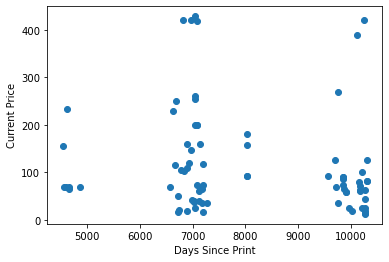

In [335]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbNG['days_since_print'], gunpla_dbNG['Current_Price'])

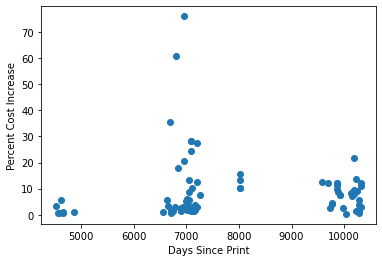

In [336]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbNG['days_since_print'], gunpla_dbNG['Percent_Change'])

In [337]:
dfNG = gunpla_dbNG.loc[gunpla_dbNG['Current_Price'] < 300]
dfNG.head()

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
93,No Grade,4.096690,34.95,7265.0,7.531277,0,0,1,0,0,0
95,No Grade,4.096690,117.28,7204.0,27.627988,0,0,1,0,0,0
96,No Grade,4.096690,16.16,7204.0,2.944648,0,0,1,0,0,0
101,No Grade,5.462254,73.73,7204.0,12.498092,0,0,1,0,0,0
107,No Grade,13.377464,65.00,7173.0,3.858918,0,0,1,0,0,0


In [338]:
gunpla_dbFinal = pd.concat([dfHG, dfMG, dfPG, dfRG, dfSD, dfNG])
gunpla_dbFinal

,Grade,Cost_USD,Current_Price,days_since_print,Percent_Change,High Grade,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
22,High Grade,13.655634,52.19,86.0,2.821866,1,0,0,0,0,0
42,High Grade,21.849015,85.00,107.0,2.890336,1,0,0,0,0,0
57,High Grade,20.483451,56.54,100.0,1.760277,1,0,0,0,0,0
61,High Grade,21.849015,70.00,107.0,2.203806,1,0,0,0,0,0
73,High Grade,13.655634,29.95,121.0,1.193234,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1530,No Grade,6.827817,92.00,9578.0,12.474292,0,0,1,0,0,0
1684,No Grade,10.924507,156.99,8026.0,13.370442,0,0,1,0,0,0
1686,No Grade,10.924507,180.00,8026.0,15.476716,0,0,1,0,0,0
1693,No Grade,8.193380,91.99,8026.0,10.227356,0,0,1,0,0,0


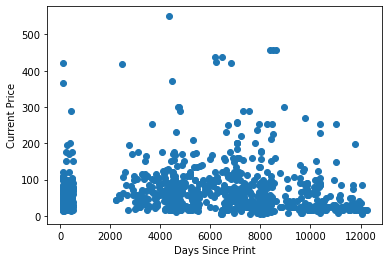

In [339]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Current Price')
plt.scatter(gunpla_dbFinal['days_since_print'], gunpla_dbFinal['Current_Price'])

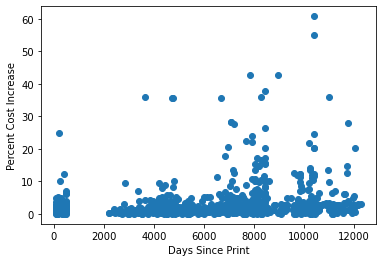

In [340]:
%matplotlib inline
plt.xlabel('Days Since Print')
plt.ylabel('Percent Cost Increase')
plt.scatter(gunpla_dbFinal['days_since_print'], gunpla_dbFinal['Percent_Change'])

## Modeling

With the outliers removed, all the data is recombined into one dataframe. We then use GridSearchCV to find parameters that create the most accurate model. 

In [355]:
gunpla_data = gunpla_dbFinal.drop(['Current_Price', 'Percent_Change', 'High Grade', 'Grade'], axis = 1)
gunpla_data

,Cost_USD,days_since_print,Master Grade,No Grade,Perfect Grade,Real Grade,Super Deformed
22,13.655634,86.0,0,0,0,0,0
42,21.849015,107.0,0,0,0,0,0
57,20.483451,100.0,0,0,0,0,0
61,21.849015,107.0,0,0,0,0,0
73,13.655634,121.0,0,0,0,0,0
...,...,...,...,...,...,...,...
1530,6.827817,9578.0,0,1,0,0,0
1684,10.924507,8026.0,0,1,0,0,0
1686,10.924507,8026.0,0,1,0,0,0
1693,8.193380,8026.0,0,1,0,0,0


In [351]:
gunpla_target = gunpla_dbFinal['Percent_Change']
gunpla_target

22       2.821866
42       2.890336
57       1.760277
61       2.203806
73       1.193234
          ...    
1530    12.474292
1684    13.370442
1686    15.476716
1693    10.227356
1694    10.227356
Name: Percent_Change, Length: 910, dtype: float64

In [347]:
from sklearn.model_selection import GridSearchCV

In [346]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [372]:
model_params = {
    'svm' : {
        'model' : svm.SVR(gamma = 'auto'),
        'params' : {
            'C' : [1, 10, 20],
            'kernel' : ['rbf', 'linear']
        }
    }
}

In [373]:
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    print(mp)
    clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
    clf.fit(gunpla_data,  gunpla_target)
    scores.append({
        'model' : model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf. best_params_
    })

svm
{'model': SVR(gamma='auto'), 'params': {'C': [1, 10, 20], 'kernel': ['rbf', 'linear']}}


In [374]:
scores

[{'model': 'svm',
  'best_score': -0.3031352414797982,
  'best_params': {'C': 1, 'kernel': 'rbf'}}]

# Conclusion

The model score based on the model chosen and data provided is in the negatives, showing poor fit. When looking at the plots of data on all the scale models, there were really no discernable patterns. The initial data was incomplete since not all the model kits's reprint dates are known or can be properly found, which makes their days since the last reprint be extraordinarily high, skewing the data. In addition, only ebay was used to find the second hand price for the model kits. A single seller on the low or high ends would also skew the data as well. 

After completing this project, there are certain things I would do in the future to improve the accuracy of the model. The main thing would be adding additional parameters in the dataframe to use in the data. Besides last reprint date, other factors can affect pricing. These would include popularity of the series the model kit is from, popularity of the design of each model kit itself, size of the gundam that it is based on, and number of other variations of the kit there are. Current pricing can also be taken from a variety of USA based sellers for their initial MSRP price and second hand pricing can be taken from other websites like Craigslist and Facebook Market. Finally, being able to get a more official and complete calendar of past reprints for all model kits would drastically improve aaccuracy as well. 